# Plot scan

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from auxPlots import readContours,label_line
import seaborn as sns
pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']

### Load Recast Data

In [2]:
files = {'ATLAS-SUSY-2018-13' :'../pp2BB1j_2018_13.pcl',
         'ATLAS-SUSY-2016-08' :'../pp2BB1j_2016_08.pcl',
         'CMS-EXO-20-004' :'../pp2BB1j_cms.pcl',}

recastDataDict = {label : pd.read_pickle(f) for label,f in files.items()}

In [3]:
r = recastDataDict['ATLAS-SUSY-2016-08']
r = r[r['mLLP'] == 530.]
r.T

,42
Luminosity (1/fb),32.8
$N_s$,0.1424
AccEff,0.000015
Total,"(9350.0, 1.0)"
Jet+MET selection,"(756.3, 0.08089)"
DV selection,"(0.1424, 1.523e-05)"
mLLP,530.0
mLSP,500.0
width,0.0
tau_ns,0.048


### Get all model points

In [30]:
# msb = '$m_{\tilde b}$'
# mn1= '$m_{\tilde \chi_1^0}$'
msb = 'mLLP'
mn1= 'mLSP'
tau = 'tau_ns'
models = []
mCols = [msb,mn1,tau]
for recastData in recastDataDict.values():
    recastData.sort_values(mCols,inplace=True)
    for row in recastData[mCols].values:
        m = dict(zip(mCols,row.tolist()))
        if m not in models:
            models.append(m)
print('%i models loaded' %len(models))

58 models loaded


### Get Model parameters

In [31]:
parameters = {label : list(set([m[label] for m in models])) for label in mCols}
for k,v in parameters.items():
    if len(v) == 1:
        parameters[k] = v[0]
print(parameters)

textstr = '\n'.join([r'%s = %s' %(k,v) for k,v in parameters.items() if k not in [msb,mn1,tau]])
print(textstr)

{'mLLP': [1410.0, 515.0, 1030.0, 520.0, 907.0, 525.0, 910.0, 530.0, 915.0, 407.0, 410.0, 1307.0, 925.0, 415.0, 1315.0, 420.0, 1320.0, 425.0, 810.0, 1707.0, 815.0, 307.0, 820.0, 310.0, 1207.0, 1210.0, 315.0, 830.0, 1215.0, 707.0, 325.0, 710.0, 715.0, 207.0, 210.0, 1107.0, 725.0, 1110.0, 215.0, 1115.0, 220.0, 733.0, 607.0, 610.0, 1507.0, 1125.0, 615.0, 1512.0, 107.0, 620.0, 110.0, 1007.0, 625.0, 1010.0, 1015.0, 507.0, 1020.0, 510.0], 'mLSP': [800.0, 900.0, 1400.0, 1700.0, 100.0, 200.0, 1000.0, 300.0, 1100.0, 400.0, 1200.0, 500.0, 1300.0, 600.0, 1500.0, 700.0], 'tau_ns': [0.8800000534791889, 1.2999999802491649, 0.3500000797630081, 0.8400000306289893, 0.36000006563355796, 0.7899999591917372, 0.34000006198724925, 0.7199999737465825, 0.3099999717411147, 0.29000002202977987, 1.1999999999999997, 0.75, 0.047999999999999994, 0.2800000340322132, 0.0989999977438469, 0.09999999999999999, 0.09599999999999999, 0.03900000711030212, 0.36999998313582577, 0.04, 0.5600000680644264, 0.12999999802491646, 0.

### Plot exclusion for each analysis

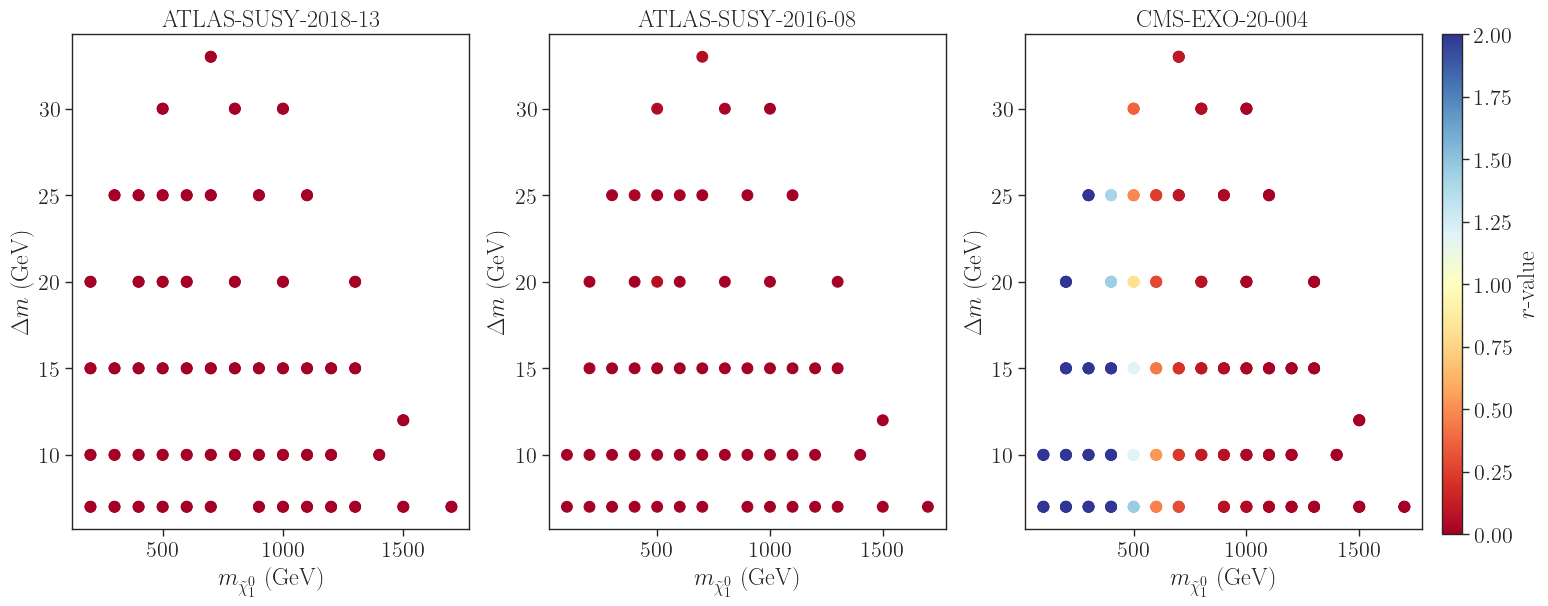

In [32]:
fig,axarr = plt.subplots(nrows=1,ncols=len(recastDataDict),figsize=(20,5))

for iplot,label in enumerate(recastDataDict):
    ax = axarr[iplot]
    recastData = recastDataDict[label]
    y = recastData[msb]-recastData[mn1]
    x = recastData[mn1]
    rValues = recastData['robs']
    p = ax.scatter(x=x,y=y,vmin=0.0,vmax=2.0,
            c=rValues,cmap=cm,s=60)
    
    ax.set_xlabel(r'$m_{\tilde \chi_1^0}$ (GeV)')
    ax.set_ylabel(r'$\Delta m$ (GeV)')
    ax.set_title('%s' %label)

fig.subplots_adjust(right=0.8,top=1.1)
cbar_ax = fig.add_axes([0.81, 0.1, 0.01, 1.0])
# fig.colorbar(r, cax=cbar_ax)    
fig.colorbar(p,label=r'$r$-value',cax=cbar_ax)
# plt.tight_layout()
plt.show()

In [35]:
recastDataDict['ATLAS-SUSY-2016-08'].columns

Index(['Luminosity (1/fb)', '$N_s$', 'AccEff', 'Total', 'Jet+MET selection',
       'DV selection', 'mLLP', 'mLSP', 'width', 'tau_ns', 'Total MC Events',
       'Total xsec (pb)', 'robs', 'rexp', 'kfactor'],
      dtype='object')

In [37]:
recastDataDict['ATLAS-SUSY-2016-08'][[msb,mn1,tau,'robs','AccEff','Total xsec (pb)']]

,mLLP,mLSP,tau_ns,robs,AccEff,Total xsec (pb)
15,107.0,100.0,1.100,0.000000,0.000000e+00,861.983659
54,110.0,100.0,0.720,0.000000,0.000000e+00,767.074133
43,207.0,200.0,1.300,0.000000,0.000000e+00,41.231078
36,210.0,200.0,0.880,0.000000,0.000000e+00,38.100387
45,215.0,200.0,0.350,0.000000,0.000000e+00,34.176133
52,220.0,200.0,0.110,0.000000,0.000000e+00,30.699991
19,307.0,300.0,1.300,0.000000,0.000000e+00,5.688372
14,310.0,300.0,0.840,0.000000,0.000000e+00,5.360117
12,315.0,300.0,0.360,0.000000,0.000000e+00,4.995261
28,325.0,300.0,0.070,0.000000,0.000000e+00,4.241371


#### Get contours from different sources

In [75]:
# Mono-Jet (CMS-EXO-20-004)
monoJetDict = readContours('./monojet_curve_sms.csv')
print('MonoJet=',monoJetDict.keys())
    
# mtt (CMS-TOP-20-001)
cmsMTTdict = readContours('./CMS_mtt_oneLoop_contours.csv')
print('cmsMTT=',cmsMTTdict.keys())
cmsMTTdictEFT = readContours('./CMS_mtt_eft_contours.csv')
print('cmsMTTEFT=',cmsMTTdictEFT.keys())

# pTt (ATLAS-TOPQ-2019-23)
atlasPTdict = readContours('./ATLAS_pT_oneLoop_contours.csv')
print('atlasPT=',atlasPTdict.keys())
atlasPTdictEFT = readContours('./ATLAS_pT_eft_contours.csv')
print('atlasPTEFT=',atlasPTdictEFT.keys())


# Direct Searches
directDict = readContours('./DirectSearches_contours.csv')
print('Direct Searches=',directDict.keys())

# # Direct searches (SModelS  + MonoJet)
# directDict = {}
# cVals = set(smodelsDict.keys()).intersection(set(monoJetDict.keys()))
# for c in cVals:
#     smodelsCurve = np.array([list(x) for x in smodelsDict[c]])
#     monoJetCurve = np.array([list(x) for x in monoJetDict[c]])
#     # interpolate in y vs x to get most constraining curve
#     f_smodels = interp1d(smodelsCurve[:,1],smodelsCurve[:,0],
#                          fill_value=-1,bounds_error=False)
#     f_mono = interp1d(monoJetCurve[:,1],monoJetCurve[:,0],
#                       fill_value=-1,bounds_error=False)
#     # Get all 
#     ypts = np.array(sorted(list(set(smodelsCurve[:,1].tolist()+monoJetCurve[:,1].tolist()))))
#     combCurve = np.array([(max(f_smodels(y),f_mono(y)),y) for y in ypts],
#                          dtype=smodelsDict[c].dtype)
#     directDict[c] = combCurve
    
# print('direct=',directDict.keys())


MonoJet= dict_keys([0.66, 1.0])
cmsMTT= dict_keys([5.0, 10.0, 12.0, 15.0, 20.0])
cmsMTTEFT= dict_keys([5.0, 10.0, 12.0, 15.0, 20.0])
atlasPT= dict_keys([5.0, 10.0])
atlasPTEFT= dict_keys([5.0, 10.0])
Direct Searches= dict_keys([0.66, 1.0])


## Version 1

In [76]:
# Select contour values:
colors = sns.color_palette('deep')
plots = {
        # 'Mono Jet' : {'contour' : 1.0, 'dataDict' : monoJetDict, 
                    #    'fill' : True, 'linestyle' : 'solid', 'color' : colors[0]},
        #  r'Stop Searches ($k=1.5$)' : {'contour' : 0.67, 'dataDict' : directDict, 
                            # 'fill' : True, 'linestyle' : 'solid', 'color' : colors[1]},
         r'Direct Searches' : {'contour' : 0.66, 'dataDict' : directDict, 
                            'fill' : True, 'linestyle' : 'solid', 'color' : colors[1]},                            
         r'$m(t\bar{t})$, $y_{DM} = 5$ (1-loop)' : {'contour' : 5.0, 'dataDict' : cmsMTTdict, 
                                                     'fill' : False, 'linestyle' : 'solid', 'color' : colors[6]},
         r'$m(t\bar{t})$, $y_{DM} = 5$ (EFT)' : {'contour' : 5.0, 'dataDict' : cmsMTTdictEFT, 
                                                     'fill' : False, 'linestyle' : 'dashed', 'color' : colors[6]},
         r'$m(t\bar{t})$, $y_{DM} = 10$ (1-loop)' : {'contour' : 10.0, 'dataDict' : cmsMTTdict, 
                                                     'fill' : False, 'linestyle' : 'solid', 'color' : colors[6]},
         r'$m(t\bar{t})$, $y_{DM} = 10$ (EFT)' : {'contour' : 10.0, 'dataDict' : cmsMTTdictEFT, 
                                                  'fill' : False, 'linestyle' : 'dashed', 'color' : colors[6]},
        #  r'$m(t\bar{t})$, $y_{DM} = 12$ (EFT)' : {'contour' : 12.0, 'dataDict' : cmsMTTdictEFT, 
                                                #   'fill' : False, 'linestyle' : 'dashed', 'color' : colors[3]},
         r'$p_T(t_h)$, $y_{DM} = 5$ (1-loop)' : {'contour' : 5.0, 'dataDict' : atlasPTdict, 
                                                     'fill' : False, 'linestyle' : 'solid', 'color' : colors[3]},
        r'$p_T(t_h)$, $y_{DM} = 5$ (EFT)' : {'contour' : 5.0, 'dataDict' : atlasPTdictEFT, 
                                                  'fill' : False, 'linestyle' : 'dashed', 'color' : colors[3]},
         r'$p_T(t_h)$, $y_{DM} = 10$ (1-loop)' : {'contour' : 10.0, 'dataDict' : atlasPTdict, 
                                                     'fill' : False, 'linestyle' : 'solid', 'color' : colors[2]},         
        #  r'$p_T(t_h)$, $y_{DM} = 5$ (EFT)' : {'contour' : 5.0, 'dataDict' : atlasPTdictEFT, 
                                                #   'fill' : False, 'linestyle' : 'dashed', 'color' : colors[5]},
        r'$p_T(t_h)$, $y_{DM} = 10$ (EFT)' : {'contour' : 10.0, 'dataDict' : atlasPTdictEFT, 
                                                  'fill' : False, 'linestyle' : 'dashed', 'color' : colors[2]},

         }


### Plot Exclusions

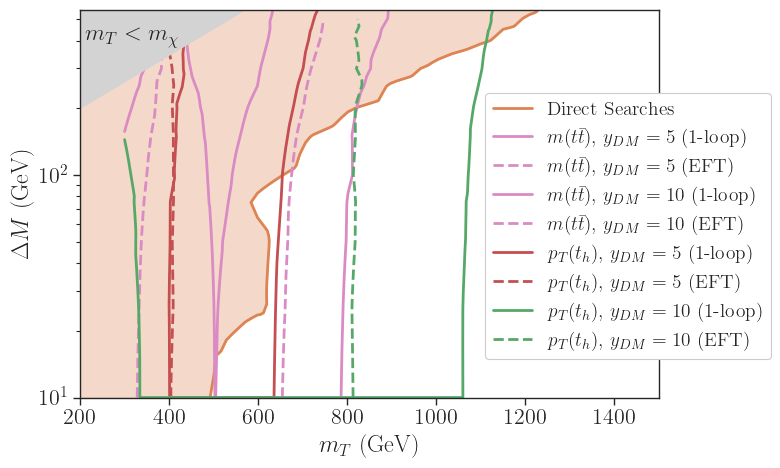

In [77]:
plt.figure(figsize=(8,5))

for p,pInfo in plots.items():
    data = pInfo['dataDict'][pInfo['contour']]
    x = data['mST_GeV']
    y = data['deltaM_GeV']    
    plt.plot(x,y,label=p,linewidth=2,color=pInfo['color'],linestyle=pInfo['linestyle'])
    if pInfo['fill']:
        plt.fill_betweenx(y,x,200,alpha=0.3,color=pInfo['color'])

plt.fill_betweenx([200.,600.],[200.,600.],color='lightgray',alpha=1.0,zorder=2)
plt.text(210.,400.,r'$m_T < m_{\chi}$',fontsize=17)


plt.legend(loc=(0.7,0.1),fontsize=14,framealpha=1.0)
plt.yscale('log')
plt.xlabel(r'$m_{T}$ (GeV)')
plt.ylabel(r'$\Delta M$ (GeV)')
plt.ylim(10.,550.)
plt.xlim(200.,1500.)
plt.tight_layout()
plt.savefig('allExclusions.png')
plt.show()

## Version 2

In [87]:
# Select contour values:
colors = sns.color_palette('Paired')
plots = {
         'Direct Searches' : {'contour' : 0.66, 'dataDict' : directDict, 'label' : 'Direct Searches', 'textLabel' : None,                              
                              'fill' : True, 'linestyle' : 'solid', 'color' : sns.color_palette('deep')[1]},      
         r'$m(t\bar{t})$, $y_{DM} = 10$ (1-loop)' : {'contour' : 10.0, 'dataDict' : cmsMTTdict, 
                                                     'label' : r'CMS - $m(\bar{t} t)$', 'textLabel' : r'$y_{DM} = 10$ (1-loop)','textoffset' : -18,
                                                     'fill' : False, 'linestyle' : 'solid', 'color' : colors[1]},
         r'$m(t\bar{t})$, $y_{DM} = 10$ (EFT)' : {'contour' : 10.0, 'dataDict' : cmsMTTdictEFT, 
                                                  'label' : None,'textLabel' : r'$y_{DM} = 10$ (EFT)','textoffset' : 20,
                                                  'fill' : False, 'linestyle' : 'dashed', 'color' : colors[1]},
         r'$p_T(t_h)$, $y_{DM} = 5$ (1-loop)' : {'contour' : 5.0, 'dataDict' : atlasPTdict, 
                                                    'label' : r'ATLAS - $p_T(t)$', 'textLabel' : r'$y_{DM} = 5$ (1-loop)','textoffset' : -10,
                                                     'fill' : False, 'linestyle' : 'solid', 'color' : colors[5]},
        r'$p_T(t_h)$, $y_{DM} = 5$ (EFT)' : {'contour' : 5.0, 'dataDict' : atlasPTdictEFT, 'textoffset' : -10,
                                                    'label' : None, 'textLabel' : r'$y_{DM} = 5$ (EFT)',
                                                  'fill' : False, 'linestyle' : 'dashed', 'color' : colors[5]},
         r'$p_T(t_h)$, $y_{DM} = 10$ (1-loop)' : {'contour' : 10.0, 'dataDict' : atlasPTdict, 
                                                     'label' : None, 'textLabel' : r'$y_{DM} = 10$ (1-loop)','textoffset' : 20,
                                                     'fill' : False, 'linestyle' : 'solid', 'color' : colors[5]},
        r'$p_T(t_h)$, $y_{DM} = 10$ (EFT)' : {'contour' : 10.0, 'dataDict' : atlasPTdictEFT, 
                                                  'label' : None, 'textLabel' : r'$y_{DM} = 10$ (EFT)','textoffset' : 20,
                                                  'fill' : False, 'linestyle' : 'dashed', 'color' : colors[5]},

         }

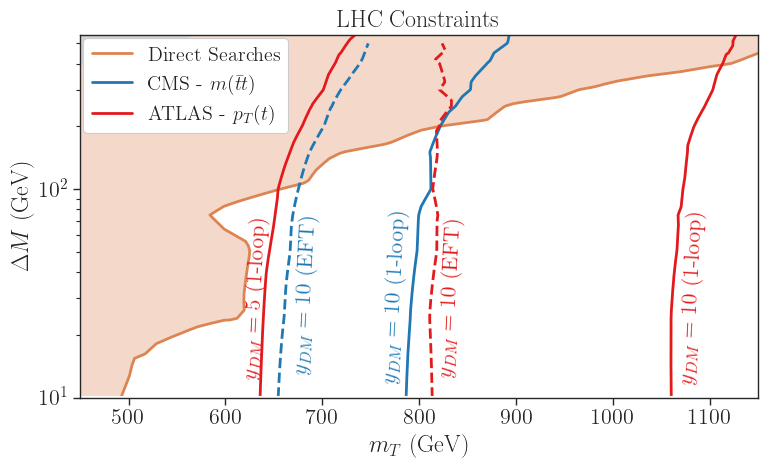

In [88]:
fig = plt.figure(figsize=(8,5))

for p,pInfo in plots.items():
    data = pInfo['dataDict'][pInfo['contour']]
    x = data['mST_GeV']
    y = data['deltaM_GeV']
    # if any(x > 450.):
        # y = y[x>450.]
        # x = x[x>450.]
    label = pInfo['label']
    txtLabel = pInfo['textLabel']
    l, = plt.plot(x,y,label=label,linewidth=2,color=pInfo['color'],linestyle=pInfo['linestyle'])
    if txtLabel:
        label_line(fig,l, txtLabel, near_y=30.,
                rotation=87.,fontsize=16,
                xmin=450.,offset=(pInfo['textoffset'],0.),boxalpha=0.0)
    
    if pInfo['fill']:
        plt.fill_betweenx(y,x,200,alpha=0.3,color=pInfo['color'])
        

plt.fill_betweenx([200.,600.],[200.,600.],color='lightgray',alpha=1.0)
# plt.text(210.,400.,r'$m_T < m_{\chi}$',fontsize=17)
plt.hlines(y=10.,xmin=0.,xmax=2000.,colors='white',linewidth=3)

plt.legend(loc=(0.005,0.73),fontsize=14.5,framealpha=1.0)
plt.yscale('log')
plt.xlabel(r'$m_{T}$ (GeV)')
plt.ylabel(r'$\Delta M$ (GeV)')
plt.xlim(450,1150)
plt.ylim(10,550)
plt.title('LHC Constraints')
plt.tight_layout()
plt.savefig('allExclusions_v2.png')
plt.show()